In [1]:
import numpy as np
import pandas as pd

In [2]:
import os
import glob

In [3]:
from scipy.optimize import curve_fit

In [4]:
import matplotlib.pyplot as plt

In [5]:
import numpy as np
from scipy.special import wofz  # Faddeeva function for Voigt profile
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [6]:
#loading dopplers
folder_path = 'spectroscopy_data/doppler/'
csv_files = glob.glob(os.path.join(folder_path, '*.CSV')) 
print(csv_files)


['spectroscopy_data/doppler\\doppler (1).CSV', 'spectroscopy_data/doppler\\doppler (2).CSV', 'spectroscopy_data/doppler\\doppler (3).CSV', 'spectroscopy_data/doppler\\doppler (4).CSV']


- 1 Loaded spectroscopy_data/doppler/doppler (1).CSV:
- 2 Loaded spectroscopy_data/doppler/doppler (2).CSV:
- 3 Loaded spectroscopy_data/doppler/doppler (3).CSV:
- 4 Loaded spectroscopy_data/doppler/doppler (4).CSV:

In [7]:
# temp = csv_files[0]
# csv_files[0] = csv_files[3]
# csv_files[3] = temp
# temp = csv_files[3]
# csv_files[3] = csv_files[2]
# csv_files[2] = temp
# temp  = csv_files[2]
# csv_files[2] = csv_files[1]
# csv_files[1]  =temp


In [8]:
dataframes_doppler = []
i=0
for file in csv_files:
    i +=1
    df = pd.read_csv(file)
    dataframes_doppler.append(df)
    print(f"{i} Loaded {file}:") 

1 Loaded spectroscopy_data/doppler\doppler (1).CSV:
2 Loaded spectroscopy_data/doppler\doppler (2).CSV:
3 Loaded spectroscopy_data/doppler\doppler (3).CSV:
4 Loaded spectroscopy_data/doppler\doppler (4).CSV:


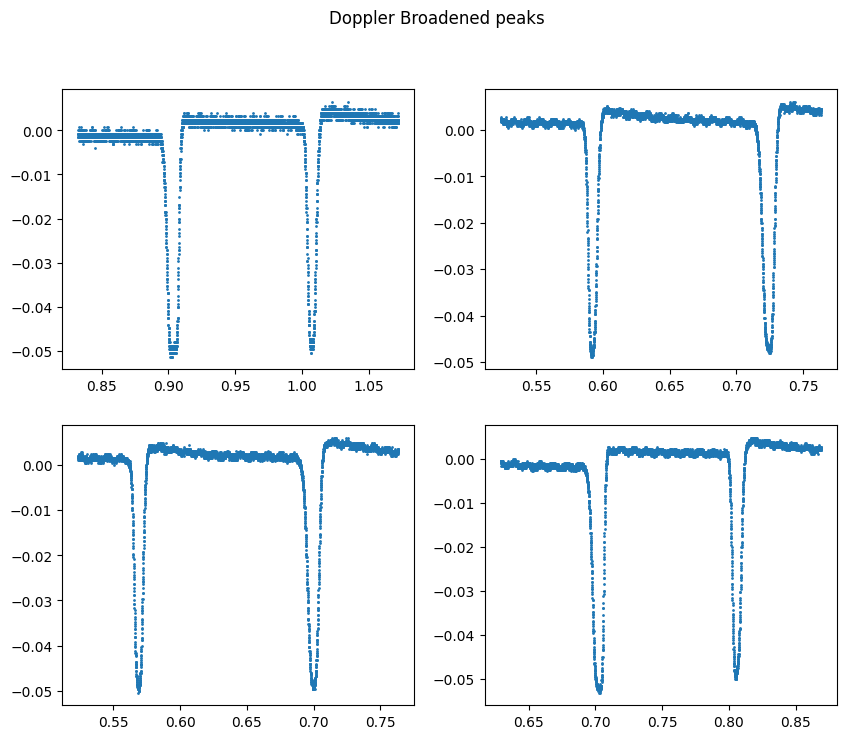

In [9]:
#fitting Doppler 
# problem - missing the CH2!! idk which dip is which..
fig, axs = plt.subplots(2,2 , figsize=(10, 8))

fig.suptitle('Doppler Broadened peaks')
for i in range(4):
    axs[i//2 , i%2].scatter(dataframes_doppler[i]['[s]'], dataframes_doppler[i]['CH1[V]'], s=1)

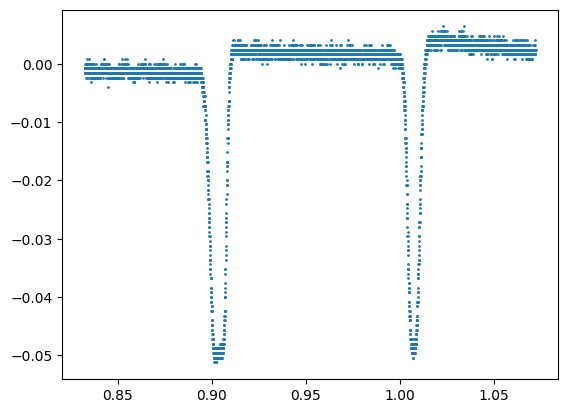

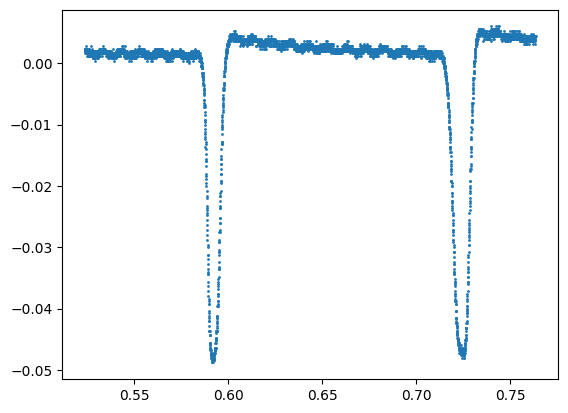

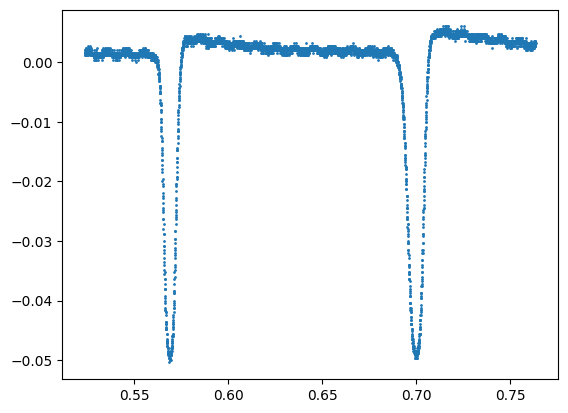

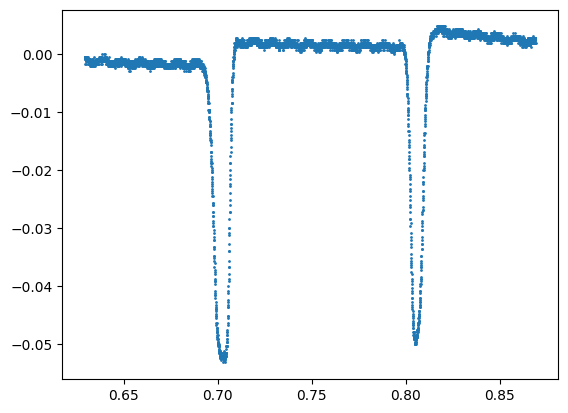

In [10]:
for i in range(4):
    x = dataframes_doppler[i]['[s]']
    y = dataframes_doppler[i]['CH1[V]']
    plt.scatter(x,y , s=1)
    # plt.xlim(0.70, 0.71)
    plt.show()

### gaussian fits on Doppler Broadened Peaks
Objective : Get the energy to time Conversion rate.
- fit each dip inside a measuremnt set with a gaussian
- for each set of 2 fits - get the distance
- compare the distance - get the erorrs

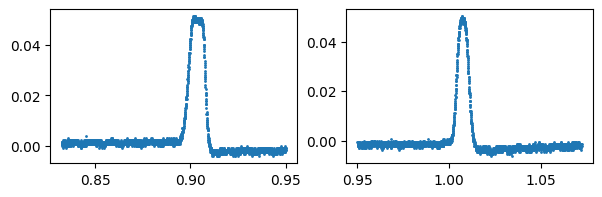

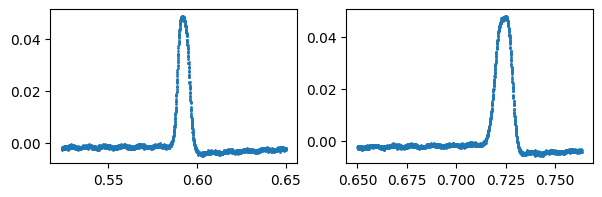

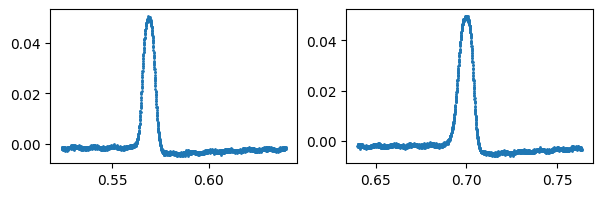

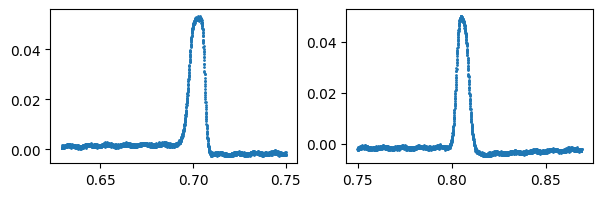

In [11]:
# df_doppler_edited = []
df_doppler_edited = np.ones((4,2), dtype=object)
cuts = [0.95, 0.65, 0.64, 0.75]

for i in range(4):
    df = dataframes_doppler[i]
    df['CH1[V]'] *= -1

    cut_index = (df['[s]'] - cuts[i]).abs().argmin()
    df1 = df.iloc[:cut_index]
    # df_doppler_edited.append(df1)
    df_doppler_edited[i, 0] = df1
    df2 = df.iloc[cut_index:]
    # df_doppler_edited.append(df2)
    df_doppler_edited[i, 1] = df2
    fig, axs = plt.subplots(1,2, figsize = (7,2))
    axs[0].scatter(df1['[s]'], df1['CH1[V]'], s=1)
    axs[ 1].scatter(df2['[s]'], df2['CH1[V]'], s=1)

# portioned dips / peaks saved in df_doppler_edited

In [12]:
#normalize
for i in range(4):
    for j in range(2):
        df_doppler_edited[i,j].loc[:,'CH1[V]'] = df_doppler_edited[i,j]['CH1[V]'] / df_doppler_edited[i,j]['CH1[V]'].abs().max()

In [13]:
#peak guesses
p0_peaks = [0.902, 1.008, 0.593, 0.725, 0.57, 0.7, 0.702, 0.805]
p0_peaks = np.array(p0_peaks).reshape(4,2)

In [14]:
#cut an area around the peak

for i in range(4):
    for j in range(2):

        # df_rn  = df_doppler_edited[i, j]
        # print(df_doppler_edited[i, j].head())

        left = p0_peaks[i, j] - 0.015
        right = p0_peaks[i, j] + 0.015
        # print(left, right)

        new_cut1  = (df_doppler_edited[i,j]['[s]'] - left).abs().argmin()
        new_cut2  = (df_doppler_edited[i,j]['[s]'] - right).abs().argmin()
        df_doppler_edited[i,j] = df_doppler_edited[i,j].iloc[new_cut1:new_cut2]
        # print(len(df_doppler_edited[i,j]))

In [15]:
# fit function
def gauss(x, x0, sigma, A): 
    return A * np.exp(-np.square(x - x0) / (2 * np.square(sigma)))

[0.90307669 0.00352561 1.09789566]
[1.00733841 0.00258219 1.06332413]
[ 0.59210066 -0.00263891  1.07653856]
[ 0.72385114 -0.00342585  1.08418091]
[0.56877397 0.0025864  1.06268966]
[0.69950757 0.00332986 1.0718359 ]
[0.70187198 0.00342421 1.08815606]
[0.80569917 0.00261708 1.06517885]


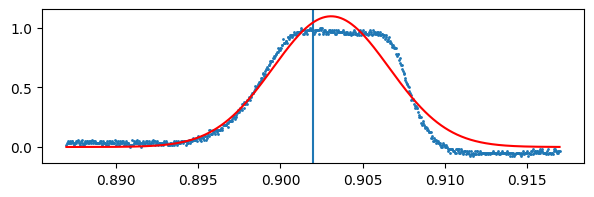

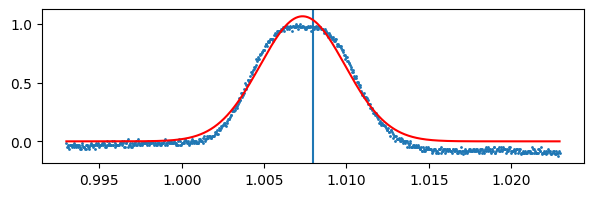

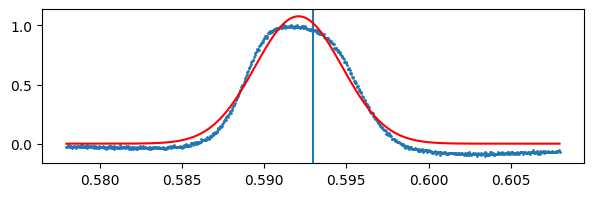

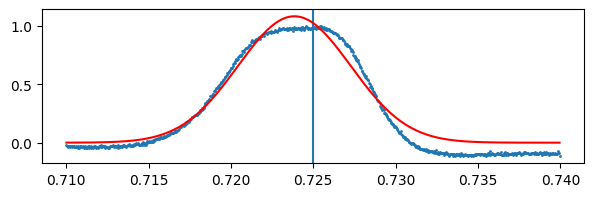

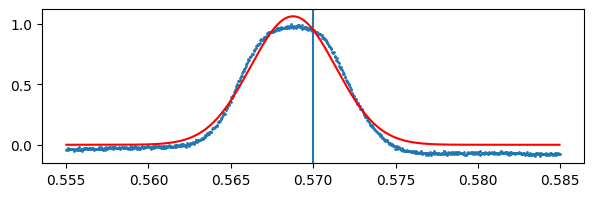

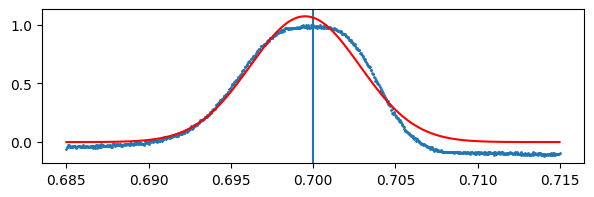

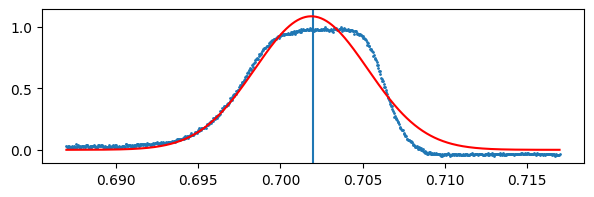

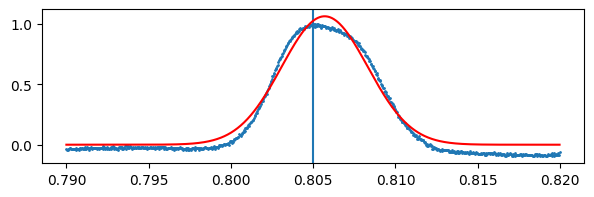

In [16]:
params  = np.zeros((4,2), dtype = object)
covs  = np.zeros((4,2), dtype = object)

for i in range(4):
    for j in range(2):
        p0 = [p0_peaks[i,j], 0.04,1]
        params[i,j], covs[i,j] = curve_fit(gauss, df_doppler_edited[i,j]['[s]'], df_doppler_edited[i,j]['CH1[V]'], p0 = p0)
        fit_y = gauss(df_doppler_edited[i,j]['[s]'], params[i,j][0], params[i,j][1], params[i,j][2]) 
        print(params[i,j])
        #plot
        xdat  =df_doppler_edited[i,j]['[s]']
        ydat = df_doppler_edited[i,j]['CH1[V]']

        fig, ax = plt.subplots( figsize = (7,2))
        ax.scatter(xdat, ydat, s=1)
        ax.axvline(p0_peaks[i,j])
        ax.plot(xdat, fit_y, color= 'red')

Text(0.5, 0.98, 'Fitted Peaks')

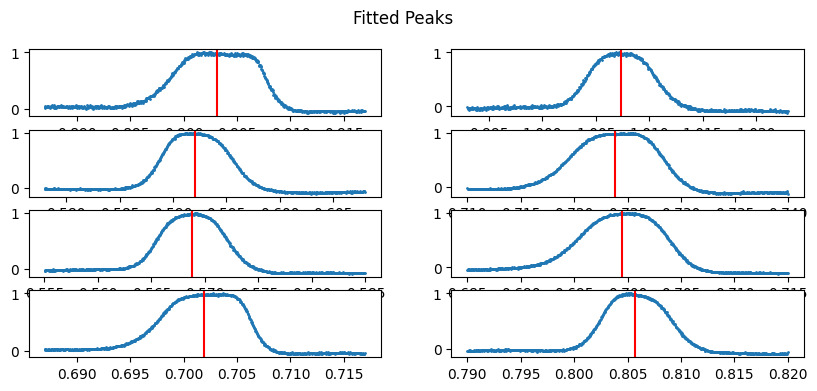

In [17]:
fig, axs = plt.subplots(4,2, figsize = (10,4))

for i in range(4):
    for j in range(2):
        xdat  =df_doppler_edited[i,j]['[s]']
        ydat = df_doppler_edited[i,j]['CH1[V]']
        axs[i,j].scatter(xdat, ydat, s=1)
        axs[i,j].axvline(params[i,j][0], color ='red')
plt.suptitle('Fitted Peaks')


In [18]:
distances = np.zeros(4)

for i in range(4):
    distances[i] = params[i,0][0] - params[i,1][0]
distances

print('conversion distance', abs(np.average(distances)), np.std(distances))
print(np.std(distances)/abs(np.average(distances)))

conversion distance 0.11764324785415611 0.013604412871833062
0.11564125540548346


In [19]:
print(distances)
alt1 = np.average(np.abs(distances[1:3]))
alt2 = np.average(np.abs([distances[0], distances[3]]))

[-0.10426172 -0.13175048 -0.1307336  -0.10382719]


In [20]:
#conversion rate
energy = 9192631770
dist = abs(np.average(distances))
rate = energy/dist
print(rate)

78139901249.54921


In [21]:
alt1 = energy/alt1 *1e-9
alt2 = energy/alt2 * 1e-9

In [22]:
print(alt1)
print(alt2)

70.04334626244966
88.35292429930405
